# Satellite Matching with Enhanced Map Generation - Tufts TURF

In [1]:
# Daniel Choate
# Enhanced map making process followed by high resolution 2D matching

In [2]:
import numpy as np
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

from groundNAV_utils import *
from colmapParsingUtils import *


%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [3]:
# Define Class Parameters 

images_c = _fn = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/images.txt"
cameras_c = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/cameras.txt"
pts3d_c = "/home/daniel-choate/ASAR/s2/TerrainNav/TTurf/points3D.txt"
# Three potential images I like 
# image_i = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9587.JPEG"
# im_ID = 145
image_i = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9446.JPEG"
im_ID = 4
# image_i = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9557.JPEG"
# im_ID = 115
# image_i = "/home/daniel-choate/Datasets/COLMAP/TTurfSAT/TTurf_Im/IMG_9570.JPEG" # Better than 9557
# im_ID = 128

# # Scene: Tufts Walkway Scene (generated by COLMAP with personal photos)
# images_c = "/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/images.txt"
# cameras_c = "/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/cameras.txt"
# pts3d_c = "/home/daniel-choate/ASAR/s2/TerrainNav/TuftsWalkway/points3D.txt"
# image_i = "/home/daniel-choate/Datasets/COLMAP/Tufts_Walkway2/Walkway_Images/IMG_7947.JPEG"
# im_ID = 40

In [4]:
# Create class 
gnav = gNAV_agent(images_c, cameras_c, pts3d_c, image_i)

# Grab raw points and RGB data 
scene_pts, rgb_data = gnav.grab_pts(gnav.pts3d)

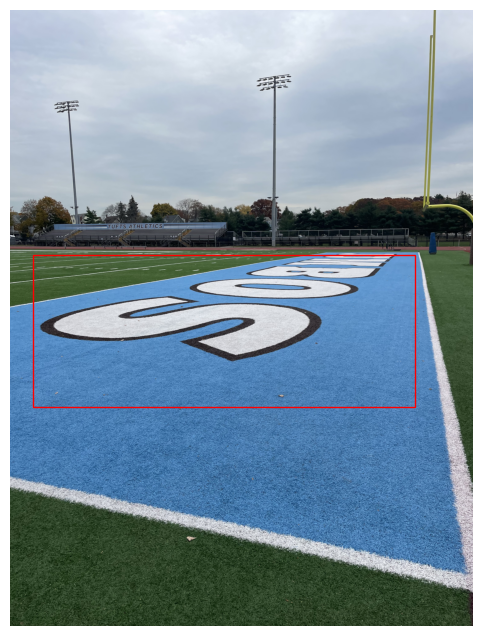

In [5]:
# Define boundaries for selected ground plane points 
x,y = 150,1600 # Top left corner of square
side_x = 2500 # WIDTH
side_y = 1000 # HEIGHT

# Plot to visualize
gnav.plot_rect_im(x, y, side_x, side_y) 

# Get necessary location and rghb data 
pts_loc, pts_rgb = gnav.grab_image_pts(x, y, side_x, side_y)
# print(pts_loc)

In [6]:
# Unit vectors in world coords
pts_vec_c, pts_rgb_gnd = gnav.unit_vec_c(pts_loc, pts_rgb)

# Get transformation matrix that move from camera coords to world coords 
homog_c2w = gnav.get_pose_id(im_ID)
print('Homogeneous transformation from world to camera \n', homog_c2w)

# Inverse for world coords to camera coords
homog_w2c = gnav.inv_homog_transform(homog_c2w)
print('\n Homogeneous transformation from camera to world \n', homog_w2c)

# Transform to world coords 
origin_w = np.array([0,0,0])
origin_c, pts_loc_w, pts_vec_w = gnav.unit_vec_tform(pts_vec_c, origin_w, homog_c2w)
print('\n New camera frame origin = ', origin_c)

Homogeneous transformation from world to camera 
 [[ 0.79304202 -0.56241779  0.23403116  0.65248268]
 [ 0.60527117  0.6841197  -0.40697304  1.15045675]
 [ 0.06878355  0.46439903  0.88295094 -5.21272475]
 [ 0.          0.          0.          1.        ]]

 Homogeneous transformation from camera to world 
 [[ 0.79304202  0.60527117  0.06878355 -0.85523476]
 [-0.56241779  0.6841197   0.46439903  2.00070207]
 [ 0.23403116 -0.40697304  0.88295094  4.91808382]
 [ 0.          0.          0.          1.        ]]

 New camera frame origin =  [ 0.65248268  1.15045675 -5.21272475]


In [7]:
# Find GRAVITY and HEIGHT
pts_gnd_idx = np.array([7389, 7387, 7385, 7379, 7375])

grav_dir = gnav.grav_SVD(pts_gnd_idx)
# REVERSE DIRECTION IF NECESSARY 
grav_dir = -grav_dir
gnav.grav_vec = grav_dir
print('Gravity vector \n', grav_dir)

h_0 = gnav.height_avg(pts_gnd_idx, origin_w)
print('\nHeight h_0 = ', h_0)

# Get new points 
ranges, new_pts = gnav.pt_range(pts_vec_w, homog_c2w, origin_c)
print('\nNew Points \n', new_pts)

Gravity vector 
 [0.82770411 0.51739239 0.21728097]

Height h_0 =  0.30954245543925707

New Points 
 [[-0.47896306 -0.45620619  4.3354913 ]
 [-0.4772088  -0.45803817  4.33317099]
 [-0.47545489 -0.45986978  4.33085115]
 ...
 [ 1.15007044  0.69523304 -4.61192646]
 [ 1.15022043  0.69504917 -4.61205997]
 [ 1.15037041  0.69486531 -4.61219347]]


In [8]:
# Plot new points 
# Use open3d to create point cloud visualization 

# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name="Originial scene with origin")

# Create axes @ origin
axis_w = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
axis_c = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1).transform(homog_c2w)

# Create point cloud for scene pts
scene_cloud = o3d.geometry.PointCloud()
scene_cloud.points = o3d.utility.Vector3dVector(scene_pts)
scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)


# Create point cloud for scene pts
scene_NEW = o3d.geometry.PointCloud()
scene_NEW.points = o3d.utility.Vector3dVector(new_pts)
scene_NEW.colors = o3d.utility.Vector3dVector(pts_rgb_gnd)
# scene_NEW.paint_uniform_color([0,0,1]) # Make all points red

# # Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2

# Add necessary geometries to visualization 
vis.add_geometry(axis_w)
vis.add_geometry(axis_c)
vis.add_geometry(scene_cloud)
vis.add_geometry(scene_NEW)

# Run and destroy visualization 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 76
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 76
pci id for fd 76: 8086:a7a0, driver iris
MESA-LOADER: dlopen(/usr/lib/x86_64-linux-gnu/dri/iris_dri.so)
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using 

In [ ]:
# # Plot unit vectors and scene 
# # Plot unit vectors (sanity check) 

# # Lets use open3d
# # Use open3d to create point cloud visualization 

# # Prepare the points and lines - camera coords
# points_c = []
# points_c.append(origin_w)
# lines_c = []
# # Prepare the points and lines - world coords
# points_w = []
# points_w.append(origin_c)
# lines_w = []

# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Unit vector verification")

# # Create axes @ origin
# axis_w = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
# axis_c = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1).transform(homog_c2w)

# # Create point cloud for scene pts
# scene_cloud = o3d.geometry.PointCloud()
# scene_cloud.points = o3d.utility.Vector3dVector(scene_pts)
# scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)

# # Add the points and lines
# count = 0
# for i in range(0, len(pts_vec_c), 135):
#     # Origin is at [0,0,0] and the vectors are in pts_vec_c
#     # print(pts_vec_c[i])
#     points_c.append(pts_vec_c[i])
#     points_w.append(pts_loc_w[i])
    
#     # Create a line between origin and the vector endpoint
#     lines_c.append([0, count + 1])
#     lines_w.append([0, count + 1])
#     count += 1


# # Convert points and lines to numpy arrays
# points_c = np.array(points_c)
# points_w = np.array(points_w)
# lines_c = np.array(lines_c)
# lines_w = np.array(lines_w)

# # Create LineSet
# line_set_40_c = o3d.geometry.LineSet()
# line_set_40_c.points = o3d.utility.Vector3dVector(points_c)
# line_set_40_c.lines = o3d.utility.Vector2iVector(lines_c)
# # line_set_40_c.paint_uniform_color([1, 0, 0])  # RGB for red (1, 0, 0)

# # Create LineSet
# line_set_40_w = o3d.geometry.LineSet()
# line_set_40_w.points = o3d.utility.Vector3dVector(points_w)
# line_set_40_w.lines = o3d.utility.Vector2iVector(lines_w)
# line_set_40_w.paint_uniform_color([1, 0, 0])  # RGB for red (1, 0, 0)

# # Add necessary geometries to visualization 
# vis.add_geometry(axis_w)
# vis.add_geometry(axis_c)
# vis.add_geometry(line_set_40_c)
# vis.add_geometry(line_set_40_w)
# vis.add_geometry(scene_cloud)

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()

In [ ]:
# # FIND A FEW GROUND PLANE POINTS
# # Points we KNOW are on the ground 
# pts_gnd_idx = np.array([7389, 7387, 7385, 7379, 7375])
# pts_gnd_T = scene_pts[pts_gnd_idx]
# print(pts_gnd_T)

In [ ]:
# # Find 3 points in the ground plane

# pts_gnd_test = scene_pts[7370:7380,:]
# # pts_test = scene_pts[24146:24147,:]
# pts_gnd_test1 = np.array([scene_pts[7375,:], scene_pts[7376,:]])
# # pts_gnd_test1 = scene_pts[7380:7390,:]


# # Use open3d to create point cloud visualization 

# # Create visualization 
# vis = o3d.visualization.Visualizer()
# vis.create_window(window_name="Originial scene with origin")

# # Create axes @ origin
# axis_origin = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

# # Create point cloud for scene pts
# scene_cloud = o3d.geometry.PointCloud()
# scene_cloud.points = o3d.utility.Vector3dVector(scene_pts)
# scene_cloud.colors = o3d.utility.Vector3dVector(rgb_data)

# # Create point cloud for ground plane points
# ground_pts = o3d.geometry.PointCloud()
# ground_pts.points = o3d.utility.Vector3dVector(pts_gnd_test)
# ground_pts.paint_uniform_color([1,0,0]) # Make all points red

# # Create point cloud for MORE ground plane points
# ground_pts2 = o3d.geometry.PointCloud()
# ground_pts2.points = o3d.utility.Vector3dVector(pts_gnd_test1)
# ground_pts2.paint_uniform_color([0,1,0]) # Make all points GREEN

# # Create point cloud for MORE ground plane points
# ground_pts_TOTAL = o3d.geometry.PointCloud()
# ground_pts_TOTAL.points = o3d.utility.Vector3dVector(pts_gnd_T)
# ground_pts_TOTAL.paint_uniform_color([0,0,1]) # Make all points BLUE

# # Add necessary geometries to visualization 
# # vis.add_geometry(axis_origin)
# # vis.add_geometry(scene_cloud)
# # vis.add_geometry(ground_pts)
# # vis.add_geometry(ground_pts2)
# vis.add_geometry(ground_pts_TOTAL)

# # # Size options (jupyter gives issues when running this multiple times, but it looks better)
# # render_option = vis.get_render_option()
# # render_option.point_size = 2

# # Run and destroy visualization 
# vis.run()
# vis.destroy_window()